In [1]:
import sympy as sp
import pystencils as ps
from lbmpy.session import *

from LBMLatticeModelGeneration import *

/home/fredy/LSS/lssgit/python_includes/pystencils/sympy_gmpy_bug_workaround.py:11: UserWarning: You are using the gmpy backend. You might encounter an error 'argument is not an mpz sympy'. This is due to a known bug in sympy/gmpy library. To prevent this, import pystencils first then sympy or set the environment variable MPMATH_NOGMPY=1
  warnings.warn("You are using the gmpy backend. You might encounter an error 'argument is not an mpz sympy'. "


In [2]:
srt_params = {'stencil': STENCIL,
                'method': 'srt',
                'relaxation_rate': OMEGA}

mrt_cumulant_params = {'stencil': STENCIL,
                        'method': 'mrt_raw',
                        'relaxation_rates': [0, 0, 0, OMEGA, OMEGA, OMEGA, 1, 1, 1],
                        'cumulant': True,
                        'compressible': True}   # Incompressible cumulants not yet supported!

mrt_cumulant_collision_rule = create_lb_collision_rule(optimization=OPT, output=OUTPUT, **mrt_cumulant_params)

In [5]:
omega_f = sp.Symbol('omega_f')

mrt_entropic_params = {'stencil': STENCIL,
                        'method': 'mrt',
                        'relaxation_rates': [OMEGA, OMEGA, omega_f, omega_f],
                        'entropic': True,
                        'compressible': True}    # Entropic models only implemented with pdfs centered around 1

mrt_entropic_collision_rule = create_lb_collision_rule(optimization=OPT, output=OUTPUT, **mrt_entropic_params)

In [3]:
domain_size = (300, 80)

velocity_mag = 0.08
si_length = 1  # meters
si_time = 0.01 # seconds

si_v = velocity_mag * (si_length / si_time) # meters per second
si_v

In [10]:
from lbmpy.chapman_enskog import ChapmanEnskogAnalysis
analysis = ChapmanEnskogAnalysis(mrt_entropic_collision_rule.method)
kin_visc = analysis.get_kinematic_viscosity().subs("omega", 1.8)

In [11]:
reynolds = (si_v * si_length) / kin_visc
reynolds

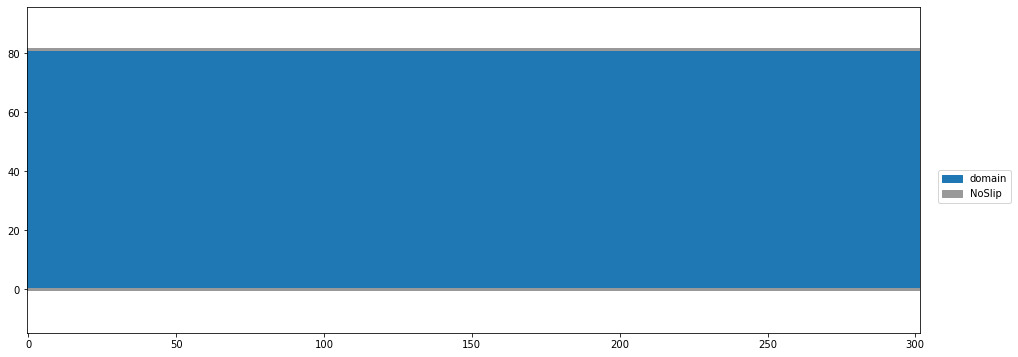

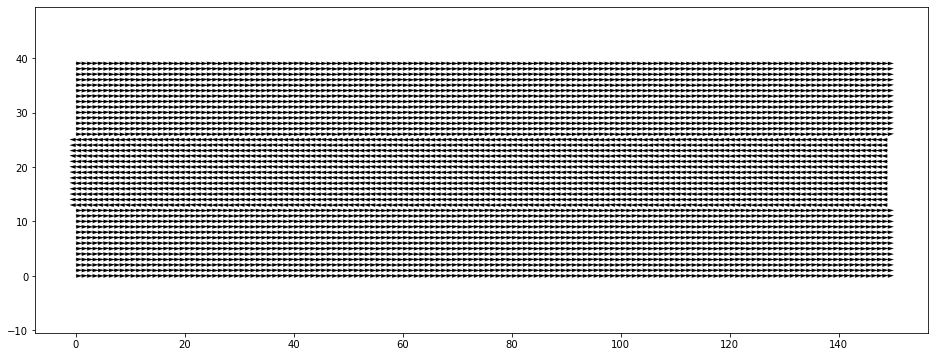

In [15]:
yThird = domain_size[1]//3
initial_velocity = np.zeros(domain_size + (2,))
initial_velocity[:, :yThird, 0] =  velocity_mag
initial_velocity[:, yThird:2*yThird, 0] = -velocity_mag
initial_velocity[:, 2*yThird:, 0] =  velocity_mag
initial_velocity[:, :, 1] += np.random.rand(*domain_size) * velocity_mag * 0.1

m_params = mrt_entropic_params
m_params['relaxation_rates'][0:2] = [1.8] * 2

step = LatticeBoltzmannStep(domain_size=domain_size, 
                           periodicity=(True, False, False),
                           optimization=OPT,
                           **mrt_entropic_params)

for b in step.data_handling.iterate(ghost_layers=False):
    np.copyto(b[step.velocity_data_name], initial_velocity[b.global_slice])
step.set_pdf_fields_from_macroscopic_values()

wall = NoSlip()
def walls_callback(xs,ys):
    walls = np.zeros_like(xs, dtype=bool)
    walls[:,0] = True
    walls[:,-1] = True
    return walls

step.boundary_handling.set_boundary(wall, mask_callback=walls_callback)
plt.figure()
plt.boundary_handling(step.boundary_handling)
plt.figure()
plt.vector_field(step.velocity[:,:])

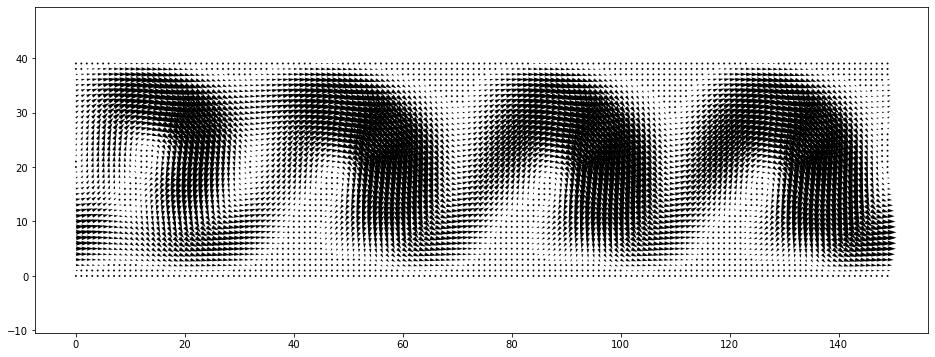

In [18]:
#step.run(10000)
plt.vector_field(step.velocity[:,:])

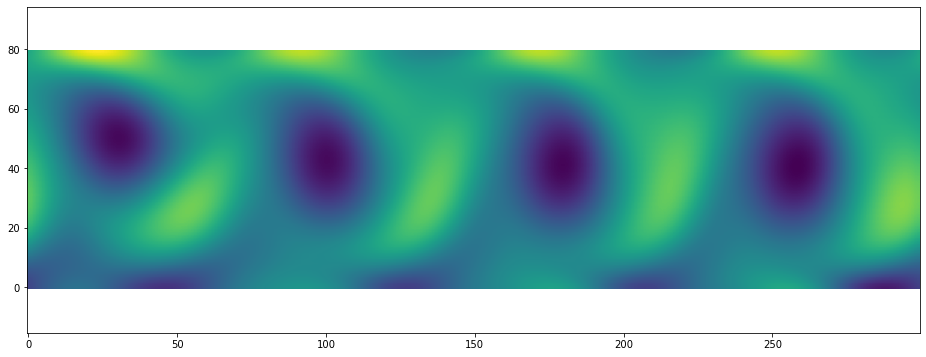

In [17]:
plt.scalar_field(vorticity_2d(step.velocity[:,:]))

In [16]:
def next_frame():
    step.run(50)
    return step.velocity[:, :]

anim = ps.plot.vector_field_animation(next_frame, frames = 200)
result = ps.jupyter.display_as_html_video(anim)
result

In [115]:
mrt_entropic_params

{'stencil': 'D2Q9',
 'method': 'mrt',
 'relaxation_rates': [1.8, 1.8, omega_f, omega_f],
 'entropic': True,
 'compressible': True}